# Step 0 : Problem defination
This model is based on toxic comment classifier database. We are provided with a set of comments alng with the categories of the comment. The training data is labeled and it s sufficiently large. we will split the train data into two sets and use train and test sets.

# Step 1 : Importing the libraries

In [0]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### Getting the data

In [0]:
from zipfile import ZipFile
with ZipFile('jigsaw-toxic-comment-classification-challenge.zip','r') as ziped:
  ziped.extractall()

In [0]:
train=pd.read_csv('train.csv')

# Step 2 :  Exploratory analysis

In [6]:
train.shape

(159571, 8)

In [0]:
from sklearn.model_selection import train_test_split
x_train=train.head(120000)
x_test=train.tail(30000)

In [0]:
train.head()

id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]

In [0]:
train['comment_text'][0]


"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

Let's check the lengths of comments.

In [0]:
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()

(394.0732213246768, 590.7202819048923, 5000)

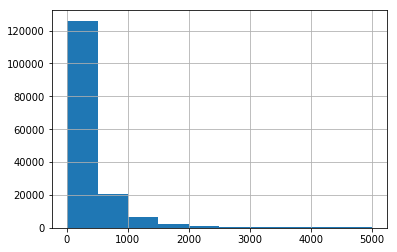

In [0]:
lens.hist();

### Statistical details of the train data

In [11]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
x_train['none'] = 1-x_train[label_cols].max(axis=1)
x_train.describe()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


toxic   severe_toxic  ...  identity_hate           none
count  120000.000000  120000.000000  ...  120000.000000  120000.000000
mean        0.095792       0.010000  ...       0.008625       0.898417
std         0.294307       0.099499  ...       0.092470       0.302101
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       1.000000
50%         0.000000       0.000000  ...       0.000000       1.000000
75%         0.000000       0.000000  ...       0.000000       1.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 7 columns]

In [9]:
len(x_train),len(x_test)


(120000, 30000)

# Step 3 : Preprocessing

In [4]:
COMMENT = 'comment_text'
x_train[COMMENT].fillna("unknown", inplace=True)
x_test[COMMENT].fillna("unknown", inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


### Tokanization

In [0]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()


### Tf-idf weights

In [0]:
n = x_train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
trn_term_doc = vec.fit_transform(x_train[COMMENT])
test_term_doc = vec.transform(x_test[COMMENT])


In [14]:
trn_term_doc, test_term_doc



(<120000x340390 sparse matrix of type '<class 'numpy.float64'>'
 	with 13216904 stored elements in Compressed Sparse Row format>,
 <30000x340390 sparse matrix of type '<class 'numpy.float64'>'
 	with 3239441 stored elements in Compressed Sparse Row format>)

# Step 4 : Building Model
### Naive Bayes feature equation

In [0]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)



In [0]:
x = trn_term_doc
test_x = test_term_doc


### Model Creator function

In [0]:
'''
from sklearn import svm
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    clf = svm.SVC(kernel='rbf')
    x_nb = x.multiply(r)
    return clf.fit(x, y), r
'''

In [0]:

def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r


# Step 5 : Prediction

In [17]:
preds = np.zeros((len(x_test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(x_train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]



fit toxic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


fit severe_toxic


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit obscene


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit threat


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit insult


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


fit identity_hate


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### Saving output to the file

In [0]:
submid = pd.DataFrame({'id': subm["id"]})
submission = pd.concat([submid, pd.DataFrame(preds, columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)


matrix([[1.0878663 , 1.89490976, 0.56984937, ..., 4.1164755 , 3.64755701,
         3.64755701]])